# Import and prep NY Times time series data for US states and counties

We use the NY Times data from https://github.com/nytimes/covid-19-data.

This notebook does the following:

* downloads lates time series data from https://github.com/nytimes/covid-19-data.
* adds an integer day column 
* all dataframes are created both in wide and long forms. 
* csvs explorted to path of your choosing
* line plots (faceted) by county (for MI) and by state


In [1]:
# Set your data export path to location where exported csvs will go.
use_local = True
if use_local:
    data_export_path = './myc19data/'
else:
    data_export_path = None

In [2]:
x_end_day = 700

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [4]:
import us # US states and metadata

In [5]:
%matplotlib inline

## Import raw data
The read csv statements below directly access the raw data residing on Github. I've also cloned the repo and can do a `git pull` to update my local copy of the entire repo. However, that is **NOT** necessary to use this notebook.

## Data from NY Times
Here's the URL to the raw data as stored at GitHub:

https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv

You can get data directly from here but I'm also including code to grab it from a local repo of the NY Times site. This avoids repeated downloads if you are working on a notebook and keep rerunning all the cells.

In [6]:
# Get data directly from NYTimes and US census
if not use_local:
    NYT_counties_path = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
    NYT_states_path = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
    pop_path = 'https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv'
else:
# Using local data that's already been downloaded or git pulled.
    local_data_path = os.environ['C19_HOME']
    NYT_counties_path = '{}/community/covid-19-data/us-counties.csv'.format(local_data_path)
    NYT_states_path = '{}/community/covid-19-data/us-states.csv'.format(local_data_path)
    pop_path = '{}/myc19data/co-est2019-alldata.csv'.format(local_data_path)

NYT_counties_df = pd.read_csv(NYT_counties_path, parse_dates=['date'])
NYT_states_df = pd.read_csv(NYT_states_path, parse_dates=['date'])
pop_df = pd.read_csv(pop_path, encoding = "utf-8")

In [7]:
pop_df.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,1,0,Alabama,Alabama,4779736,4780125,4785437,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
1,50,3,6,1,1,Alabama,Autauga County,54571,54597,54773,...,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183112,...,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
3,50,3,6,1,5,Alabama,Barbour County,27457,27455,27327,...,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
4,50,3,6,1,7,Alabama,Bibb County,22915,22915,22870,...,1.385134,-4.998356,-3.787545,-5.797999,1.331144,1.329817,-0.708717,-3.234669,-6.857092,1.831952


In [8]:
pop_df['COUNTY'].dtype

dtype('int64')

In [9]:
pop_county_2019_df = pop_df.loc[pop_df['COUNTY'] > 0,['STATE', 'COUNTY', 'POPESTIMATE2019']]
pop_state_2019_df = pop_df.loc[pop_df['COUNTY'] == 0,['STATE', 'COUNTY', 'POPESTIMATE2019']]

In [10]:
pop_county_2019_df['fips'] = pop_county_2019_df['STATE'] * 1000 + pop_county_2019_df['COUNTY']
pop_county_2019_df

,STATE,COUNTY,POPESTIMATE2019,fips
1,1,1,55869,1001
2,1,3,223234,1003
3,1,5,24686,1005
4,1,7,22394,1007
5,1,9,57826,1009
...,...,...,...,...
3188,56,37,42343,56037
3189,56,39,23464,56039
3190,56,41,20226,56041
3191,56,43,7805,56043


In [11]:
pop_state_2019_df

,STATE,COUNTY,POPESTIMATE2019
0,1,0,4903185
68,2,0,731545
98,4,0,7278717
114,5,0,3017804
190,6,0,39512223
249,8,0,5758736
314,9,0,3565287
323,10,0,973764
327,11,0,705749
329,12,0,21477737


In [12]:
NYT_counties_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816613 entries, 0 to 1816612
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   county  object        
 2   state   object        
 3   fips    float64       
 4   cases   int64         
 5   deaths  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 83.2+ MB


In [13]:
NYT_counties_df = NYT_counties_df.dropna()

In [14]:
NYT_counties_df = NYT_counties_df.astype({"fips": int})
NYT_states_df = NYT_states_df.astype({"fips": int})

In [15]:
NYT_counties_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1758890 entries, 0 to 1816612
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   county  object        
 2   state   object        
 3   fips    int64         
 4   cases   int64         
 5   deaths  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 93.9+ MB


In [16]:
NYT_states_df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [17]:
NYT_counties_df = NYT_counties_df.merge(pop_county_2019_df, how='left', left_on='fips', right_on='fips')
NYT_states_df = NYT_states_df.merge(pop_state_2019_df, how='left', left_on='fips', right_on='STATE')

In [18]:
NYT_counties_df

,date,county,state,fips,cases,deaths,STATE,COUNTY,POPESTIMATE2019
0,2020-01-21,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0
1,2020-01-22,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0
2,2020-01-23,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0
3,2020-01-24,Cook,Illinois,17031,1,0.0,17.0,31.0,5150233.0
4,2020-01-24,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0
...,...,...,...,...,...,...,...,...,...
1758885,2021-10-14,Sweetwater,Wyoming,56037,7245,75.0,56.0,37.0,42343.0
1758886,2021-10-14,Teton,Wyoming,56039,5039,13.0,56.0,39.0,23464.0
1758887,2021-10-14,Uinta,Wyoming,56041,3705,26.0,56.0,41.0,20226.0
1758888,2021-10-14,Washakie,Wyoming,56043,1574,29.0,56.0,43.0,7805.0


In [19]:
NYT_states_df

,date,state,fips,cases,deaths,STATE,COUNTY,POPESTIMATE2019
0,2020-01-21,Washington,53,1,0,53.0,0.0,7614893.0
1,2020-01-22,Washington,53,1,0,53.0,0.0,7614893.0
2,2020-01-23,Washington,53,1,0,53.0,0.0,7614893.0
3,2020-01-24,Illinois,17,1,0,17.0,0.0,12671821.0
4,2020-01-24,Washington,53,1,0,53.0,0.0,7614893.0
...,...,...,...,...,...,...,...,...
32537,2021-10-14,Virginia,51,900581,13345,51.0,0.0,8535519.0
32538,2021-10-14,Washington,53,694769,8263,53.0,0.0,7614893.0
32539,2021-10-14,West Virginia,54,257042,4048,54.0,0.0,1792147.0
32540,2021-10-14,Wisconsin,55,850140,9141,55.0,0.0,5822434.0


### Check dates

In [20]:
num_dates = NYT_states_df['date'].describe()['unique']
print('{} unique dates'.format(num_dates))
date_stats = NYT_states_df['date'].describe()
print(date_stats)

633 unique dates
count                   32542
unique                    633
top       2021-10-04 00:00:00
freq                       56
first     2020-01-21 00:00:00
last      2021-10-14 00:00:00
Name: date, dtype: object


<ipython-input-20-0a7c8b33c870>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  num_dates = NYT_states_df['date'].describe()['unique']
<ipython-input-20-0a7c8b33c870>:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  date_stats = NYT_states_df['date'].describe()


In [21]:
# Add integer day column for simple x-axis 
d0 = date_stats['first']
dn = date_stats['last']
NYT_counties_df['day'] = NYT_counties_df.loc[:, 'date'].map(lambda x: (x - d0).days)
NYT_states_df['day'] = NYT_states_df.loc[:, 'date'].map(lambda x: (x - d0).days)

# Add previous sunday date to facilitate easy grouping by week
NYT_counties_df['prev_sunday'] = NYT_counties_df['date'] - pd.offsets.Week(weekday=6)
NYT_states_df['prev_sunday'] = NYT_states_df['date'] - pd.offsets.Week(weekday=6)

week_stats = NYT_states_df['prev_sunday'].describe()
w0 = week_stats['first']
wn = week_stats['last']
NYT_counties_df['week'] = NYT_counties_df.loc[:, 'prev_sunday'].map(lambda x: int(((x - w0).days)/7))
NYT_states_df['week'] = NYT_states_df.loc[:, 'prev_sunday'].map(lambda x: int(((x - w0).days)/7))

<ipython-input-21-3f32b5afa3b0>:11: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  week_stats = NYT_states_df['prev_sunday'].describe()


In [22]:
week_stats

count                   32542
unique                     91
top       2021-10-03 00:00:00
freq                      392
first     2020-01-19 00:00:00
last      2021-10-10 00:00:00
Name: prev_sunday, dtype: object

In [23]:
NYT_states_df

,date,state,fips,cases,deaths,STATE,COUNTY,POPESTIMATE2019,day,prev_sunday,week
0,2020-01-21,Washington,53,1,0,53.0,0.0,7614893.0,0,2020-01-19,0
1,2020-01-22,Washington,53,1,0,53.0,0.0,7614893.0,1,2020-01-19,0
2,2020-01-23,Washington,53,1,0,53.0,0.0,7614893.0,2,2020-01-19,0
3,2020-01-24,Illinois,17,1,0,17.0,0.0,12671821.0,3,2020-01-19,0
4,2020-01-24,Washington,53,1,0,53.0,0.0,7614893.0,3,2020-01-19,0
...,...,...,...,...,...,...,...,...,...,...,...
32537,2021-10-14,Virginia,51,900581,13345,51.0,0.0,8535519.0,632,2021-10-10,90
32538,2021-10-14,Washington,53,694769,8263,53.0,0.0,7614893.0,632,2021-10-10,90
32539,2021-10-14,West Virginia,54,257042,4048,54.0,0.0,1792147.0,632,2021-10-10,90
32540,2021-10-14,Wisconsin,55,850140,9141,55.0,0.0,5822434.0,632,2021-10-10,90


## Add state abbreviations
We'll create a mapping dictionary from the `us` package.

In [24]:
us_state_abbrev = us.states.mapping('name', 'abbr')
#us_state_abbrev

In [25]:
NYT_counties_df.loc[:, 'st'] = NYT_counties_df.loc[:, 'state'].map(lambda x: us_state_abbrev[x])
NYT_states_df.loc[:, 'st'] = NYT_states_df.loc[:, 'state'].map(lambda x: us_state_abbrev[x])

In [26]:
NYT_counties_df.head()

,date,county,state,fips,cases,deaths,STATE,COUNTY,POPESTIMATE2019,day,prev_sunday,week,st
0,2020-01-21,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0,0,2020-01-19,0,WA
1,2020-01-22,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0,1,2020-01-19,0,WA
2,2020-01-23,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0,2,2020-01-19,0,WA
3,2020-01-24,Cook,Illinois,17031,1,0.0,17.0,31.0,5150233.0,3,2020-01-19,0,IL
4,2020-01-24,Snohomish,Washington,53061,1,0.0,53.0,61.0,822083.0,3,2020-01-19,0,WA


In [27]:
NYT_states_df.loc[NYT_states_df['state'] == 'Virginia'].tail()

,date,state,fips,cases,deaths,STATE,COUNTY,POPESTIMATE2019,day,prev_sunday,week,st
32313,2021-10-10,Virginia,51,888159,13075,51.0,0.0,8535519.0,628,2021-10-03,89,VA
32369,2021-10-11,Virginia,51,893607,13175,51.0,0.0,8535519.0,629,2021-10-10,90,VA
32425,2021-10-12,Virginia,51,895619,13219,51.0,0.0,8535519.0,630,2021-10-10,90,VA
32481,2021-10-13,Virginia,51,897978,13285,51.0,0.0,8535519.0,631,2021-10-10,90,VA
32537,2021-10-14,Virginia,51,900581,13345,51.0,0.0,8535519.0,632,2021-10-10,90,VA


## Compute some first diffs
Be nice to have first diffs of the cumulative counts and some 1-week moving averages. Have to be careful because dataframes are ordered by date by location and direct diffs make no sense. There's also some pandas trickiness with these, especially the rolling means within groups.

In [28]:
NYT_states_df = NYT_states_df.sort_values(by=['state', 'date'])
NYT_states_df['cases_diff'] = NYT_states_df.groupby(['state'])['cases'].diff().fillna(0)
NYT_states_df['cases_ma7'] = NYT_states_df.groupby('state')['cases_diff'].transform(lambda x: x.rolling(7, 1).mean())
NYT_states_df['cases_ma14'] = NYT_states_df.groupby('state')['cases_diff'].transform(lambda x: x.rolling(14, 1).mean())
NYT_states_df['deaths_diff'] = NYT_states_df.groupby(['state'])['deaths'].diff().fillna(0)
NYT_states_df['deaths_ma7'] = NYT_states_df.groupby('state')['deaths_diff'].transform(lambda x: x.rolling(7, 1).mean())
NYT_states_df['deaths_ma14'] = NYT_states_df.groupby('state')['deaths_diff'].transform(lambda x: x.rolling(14, 1).mean())

NYT_counties_df = NYT_counties_df.sort_values(by=['state', 'county', 'fips', 'date'])
# NYT_counties_df.info() - there all nulls for some counties due to unknown fips
NYT_counties_df.dropna(inplace=True)

NYT_counties_df['cases_diff'] = NYT_counties_df.groupby(['fips'])['cases'].diff().fillna(0)
NYT_counties_df['cases_ma7'] = \
    NYT_counties_df.groupby('fips')['cases_diff'].transform(lambda x: x.rolling(7, 1).mean())
NYT_counties_df['deaths_diff'] = NYT_counties_df.groupby(['fips'])['deaths'].diff().fillna(0)
NYT_counties_df['deaths_ma7'] = \
    NYT_counties_df.groupby('fips')['deaths_diff'].transform(lambda x: x.rolling(7, 1).mean())

In [29]:
NYT_states_df.head()

,date,state,fips,cases,deaths,STATE,COUNTY,POPESTIMATE2019,day,prev_sunday,week,st,cases_diff,cases_ma7,cases_ma14,deaths_diff,deaths_ma7,deaths_ma14
586,2020-03-13,Alabama,1,6,0,1.0,0.0,4903185.0,52,2020-03-08,7,AL,0.0,0.000000,0.000000,0.0,0.0,0.0
637,2020-03-14,Alabama,1,12,0,1.0,0.0,4903185.0,53,2020-03-08,7,AL,6.0,3.000000,3.000000,0.0,0.0,0.0
689,2020-03-15,Alabama,1,23,0,1.0,0.0,4903185.0,54,2020-03-08,7,AL,11.0,5.666667,5.666667,0.0,0.0,0.0
742,2020-03-16,Alabama,1,29,0,1.0,0.0,4903185.0,55,2020-03-15,8,AL,6.0,5.750000,5.750000,0.0,0.0,0.0
795,2020-03-17,Alabama,1,39,0,1.0,0.0,4903185.0,56,2020-03-15,8,AL,10.0,6.600000,6.600000,0.0,0.0,0.0


In [30]:
NYT_counties_df.head()

,date,county,state,fips,cases,deaths,STATE,COUNTY,POPESTIMATE2019,day,prev_sunday,week,st,cases_diff,cases_ma7,deaths_diff,deaths_ma7
9327,2020-03-24,Autauga,Alabama,1001,1,0.0,1.0,1.0,55869.0,63,2020-03-22,9,AL,0.0,0.000000,0.0,0.0
10656,2020-03-25,Autauga,Alabama,1001,4,0.0,1.0,1.0,55869.0,64,2020-03-22,9,AL,3.0,1.500000,0.0,0.0
12162,2020-03-26,Autauga,Alabama,1001,6,0.0,1.0,1.0,55869.0,65,2020-03-22,9,AL,2.0,1.666667,0.0,0.0
13795,2020-03-27,Autauga,Alabama,1001,6,0.0,1.0,1.0,55869.0,66,2020-03-22,9,AL,0.0,1.250000,0.0,0.0
15548,2020-03-28,Autauga,Alabama,1001,6,0.0,1.0,1.0,55869.0,67,2020-03-22,9,AL,0.0,1.000000,0.0,0.0


## Rename columns
Sinces cases is actually cumulative cases...

In [31]:
NYT_states_df.rename(columns={'cases': 'cases_cumulative',
                             'cases_diff': 'cases',
                             'deaths': 'deaths_cumulative',
                             'deaths_diff': 'deaths',}, inplace=True)

NYT_counties_df.rename(columns={'cases': 'cases_cumulative',
                             'cases_diff': 'cases',
                             'deaths': 'deaths_cumulative',
                             'deaths_diff': 'deaths',}, inplace=True)

NYT_states_df.head()

,date,state,fips,cases_cumulative,deaths_cumulative,STATE,COUNTY,POPESTIMATE2019,day,prev_sunday,week,st,cases,cases_ma7,cases_ma14,deaths,deaths_ma7,deaths_ma14
586,2020-03-13,Alabama,1,6,0,1.0,0.0,4903185.0,52,2020-03-08,7,AL,0.0,0.000000,0.000000,0.0,0.0,0.0
637,2020-03-14,Alabama,1,12,0,1.0,0.0,4903185.0,53,2020-03-08,7,AL,6.0,3.000000,3.000000,0.0,0.0,0.0
689,2020-03-15,Alabama,1,23,0,1.0,0.0,4903185.0,54,2020-03-08,7,AL,11.0,5.666667,5.666667,0.0,0.0,0.0
742,2020-03-16,Alabama,1,29,0,1.0,0.0,4903185.0,55,2020-03-15,8,AL,6.0,5.750000,5.750000,0.0,0.0,0.0
795,2020-03-17,Alabama,1,39,0,1.0,0.0,4903185.0,56,2020-03-15,8,AL,10.0,6.600000,6.600000,0.0,0.0,0.0


## Compute per capita cases (per 100000 pop)

In [32]:
NYT_states_df['cases_ma7_per100k'] = NYT_states_df['cases_ma7'] / (NYT_states_df['POPESTIMATE2019'] / 100000)
NYT_counties_df['cases_ma7_per100k'] = NYT_counties_df['cases_ma7'] / (NYT_counties_df['POPESTIMATE2019'] / 100000)

NYT_states_df['deaths_ma7_per100k'] = NYT_states_df['deaths_ma7'] / (NYT_states_df['POPESTIMATE2019'] / 100000)
NYT_counties_df['deaths_ma7_per100k'] = NYT_counties_df['deaths_ma7'] / (NYT_counties_df['POPESTIMATE2019'] / 100000)

NYT_states_df

,date,state,fips,cases_cumulative,deaths_cumulative,STATE,COUNTY,POPESTIMATE2019,day,prev_sunday,week,st,cases,cases_ma7,cases_ma14,deaths,deaths_ma7,deaths_ma14,cases_ma7_per100k,deaths_ma7_per100k
586,2020-03-13,Alabama,1,6,0,1.0,0.0,4903185.0,52,2020-03-08,7,AL,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
637,2020-03-14,Alabama,1,12,0,1.0,0.0,4903185.0,53,2020-03-08,7,AL,6.0,3.000000,3.000000,0.0,0.000000,0.000000,0.061185,0.000000
689,2020-03-15,Alabama,1,23,0,1.0,0.0,4903185.0,54,2020-03-08,7,AL,11.0,5.666667,5.666667,0.0,0.000000,0.000000,0.115571,0.000000
742,2020-03-16,Alabama,1,29,0,1.0,0.0,4903185.0,55,2020-03-15,8,AL,6.0,5.750000,5.750000,0.0,0.000000,0.000000,0.117271,0.000000
795,2020-03-17,Alabama,1,39,0,1.0,0.0,4903185.0,56,2020-03-15,8,AL,10.0,6.600000,6.600000,0.0,0.000000,0.000000,0.134606,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32317,2021-10-10,Wyoming,56,94303,1041,56.0,0.0,578759.0,628,2021-10-03,89,WY,0.0,447.714286,459.785714,0.0,6.428571,6.142857,77.357637,1.110751
32373,2021-10-11,Wyoming,56,95137,1041,56.0,0.0,578759.0,629,2021-10-10,90,WY,834.0,451.142857,443.000000,0.0,6.428571,6.142857,77.950037,1.110751
32429,2021-10-12,Wyoming,56,95620,1080,56.0,0.0,578759.0,630,2021-10-10,90,WY,483.0,443.285714,442.142857,39.0,5.571429,6.000000,76.592453,0.962651
32485,2021-10-13,Wyoming,56,96059,1080,56.0,0.0,578759.0,631,2021-10-10,90,WY,439.0,425.142857,435.285714,0.0,5.571429,6.000000,73.457667,0.962651


## Wide to long format by melting the measures

In [33]:
NYT_states_long_df = pd.melt(NYT_states_df, 
  id_vars=['date', 'state', 'fips', 'day', 'st'],
                       value_vars=['cases', 'deaths', 'cases_cumulative', 'deaths_cumulative', 'cases_ma7', 'deaths_ma7', 'cases_ma7_per100k'],
                       var_name='measure', value_name='num_cases')

NYT_counties_long_df = pd.melt(NYT_counties_df, 
  id_vars=['date', 'county', 'state', 'fips', 'day', 'st'],
                       value_vars=['cases', 'deaths', 'cases_cumulative', 'deaths_cumulative', 'cases_ma7', 'deaths_ma7', 'cases_ma7_per100k'],
                       var_name='measure', value_name='num_cases')

## Export results

In [34]:
if data_export_path:
    NYT_counties_df.to_csv("{}NYT_counties.csv".format(data_export_path), index=False)
    NYT_states_df.to_csv("{}NYT_states.csv".format(data_export_path), index=False)

    NYT_counties_long_df.to_csv("{}NYT_counties_long.csv".format(data_export_path), index=False)
    NYT_states_long_df.to_csv("{}NYT_states_long.csv".format(data_export_path), index=False)

## Sample plots

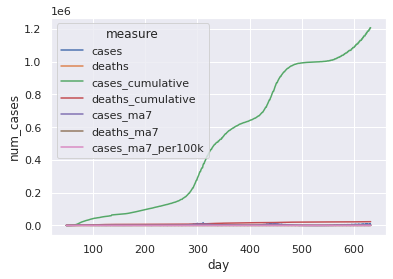

In [35]:
sns.lineplot(x='day', y='num_cases', hue='measure', 
             data=NYT_states_long_df.loc[(NYT_states_long_df['st'] == 'MI') & 
                                         (NYT_states_long_df['measure'] != 'cases_cum') &
                                         (NYT_states_long_df['measure'] != 'deaths_cum')]);

<AxesSubplot:xlabel='day', ylabel='num_cases'>

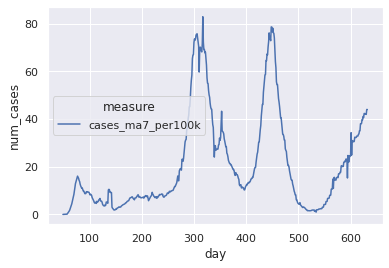

In [36]:
sns.lineplot(x='day', y='num_cases', hue='measure', 
             data=NYT_states_long_df.loc[(NYT_states_long_df['st'] == 'MI') & 
                                         (NYT_states_long_df['measure'] == 'cases_ma7_per100k')])

In [37]:
mich_df = NYT_counties_df.loc[NYT_counties_df['st'].isin(['MI'])]
mich_df.to_csv('mich_df.csv', index=None)
mich_df

,date,county,state,fips,cases_cumulative,deaths_cumulative,STATE,COUNTY,POPESTIMATE2019,day,prev_sunday,week,st,cases,cases_ma7,deaths,deaths_ma7,cases_ma7_per100k,deaths_ma7_per100k
59461,2020-04-15,Alcona,Michigan,26001,1,0.0,26.0,1.0,10405.0,85,2020-04-12,12,MI,0.0,0.000000,0.0,0.000000,0.000000,0.000000
62154,2020-04-16,Alcona,Michigan,26001,1,0.0,26.0,1.0,10405.0,86,2020-04-12,12,MI,0.0,0.000000,0.0,0.000000,0.000000,0.000000
64863,2020-04-17,Alcona,Michigan,26001,1,0.0,26.0,1.0,10405.0,87,2020-04-12,12,MI,0.0,0.000000,0.0,0.000000,0.000000,0.000000
67581,2020-04-18,Alcona,Michigan,26001,1,0.0,26.0,1.0,10405.0,88,2020-04-12,12,MI,0.0,0.000000,0.0,0.000000,0.000000,0.000000
70315,2020-04-19,Alcona,Michigan,26001,1,0.0,26.0,1.0,10405.0,89,2020-04-12,12,MI,0.0,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744501,2021-10-10,Wexford,Michigan,26165,3377,51.0,26.0,165.0,33631.0,628,2021-10-03,89,MI,0.0,16.857143,0.0,0.142857,50.123823,0.424778
1747641,2021-10-11,Wexford,Michigan,26165,3395,51.0,26.0,165.0,33631.0,629,2021-10-10,90,MI,18.0,14.000000,0.0,0.142857,41.628260,0.424778
1750781,2021-10-12,Wexford,Michigan,26165,3395,51.0,26.0,165.0,33631.0,630,2021-10-10,90,MI,0.0,14.000000,0.0,0.142857,41.628260,0.424778
1753921,2021-10-13,Wexford,Michigan,26165,3433,51.0,26.0,165.0,33631.0,631,2021-10-10,90,MI,38.0,14.142857,0.0,0.000000,42.053038,0.000000


In [38]:
semi_counties = ['Oakland', 'Macomb', 'Wayne', 'Washtenaw', 'St. Clair', 'Genesee', 'Monroe', 'Lapeer']
semich_df = NYT_counties_df.loc[NYT_counties_df['county'].isin(semi_counties) & NYT_counties_df['st'].isin(['MI'])]
semich_df.to_csv('semich_df.csv', index=None)
semich_df

,date,county,state,fips,cases_cumulative,deaths_cumulative,STATE,COUNTY,POPESTIMATE2019,day,prev_sunday,week,st,cases,cases_ma7,deaths,deaths_ma7,cases_ma7_per100k,deaths_ma7_per100k
4675,2020-03-19,Genesee,Michigan,26049,1,0.0,26.0,49.0,405813.0,58,2020-03-15,8,MI,0.0,0.000000,0.0,0.000000,0.000000,0.000000
5480,2020-03-20,Genesee,Michigan,26049,1,0.0,26.0,49.0,405813.0,59,2020-03-15,8,MI,0.0,0.000000,0.0,0.000000,0.000000,0.000000
6429,2020-03-21,Genesee,Michigan,26049,7,0.0,26.0,49.0,405813.0,60,2020-03-15,8,MI,6.0,2.000000,0.0,0.000000,0.492838,0.000000
7487,2020-03-22,Genesee,Michigan,26049,14,0.0,26.0,49.0,405813.0,61,2020-03-15,8,MI,7.0,3.250000,0.0,0.000000,0.800861,0.000000
8638,2020-03-23,Genesee,Michigan,26049,23,0.0,26.0,49.0,405813.0,62,2020-03-22,9,MI,9.0,4.400000,0.0,0.000000,1.084243,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744500,2021-10-10,Wayne,Michigan,26163,190419,5464.0,26.0,163.0,1749343.0,628,2021-10-03,89,MI,0.0,457.571429,0.0,6.000000,26.156759,0.342986
1747640,2021-10-11,Wayne,Michigan,26163,191660,5473.0,26.0,163.0,1749343.0,629,2021-10-10,90,MI,1241.0,467.857143,9.0,6.428571,26.744735,0.367485
1750780,2021-10-12,Wayne,Michigan,26163,191660,5473.0,26.0,163.0,1749343.0,630,2021-10-10,90,MI,0.0,467.857143,0.0,6.428571,26.744735,0.367485
1753920,2021-10-13,Wayne,Michigan,26163,192783,5494.0,26.0,163.0,1749343.0,631,2021-10-10,90,MI,1123.0,475.000000,21.0,5.857143,27.153051,0.334820


In [39]:
mich_weekly_df = mich_df.groupby(['county', 'week'])[['cases', 'deaths']].sum()
mich_weekly_df.reset_index(drop=False, inplace=True)
mich_weekly_df['cases_ma4'] = mich_weekly_df.groupby('county')['cases'].transform(lambda x: x.rolling(4, 1).mean())

semich_weekly_df = semich_df.groupby(['county', 'week'])[['cases', 'deaths']].sum()
semich_weekly_df.reset_index(drop=False, inplace=True)
semich_weekly_df['cases_ma4'] = semich_weekly_df.groupby('county')['cases'].transform(lambda x: x.rolling(4, 1).mean())

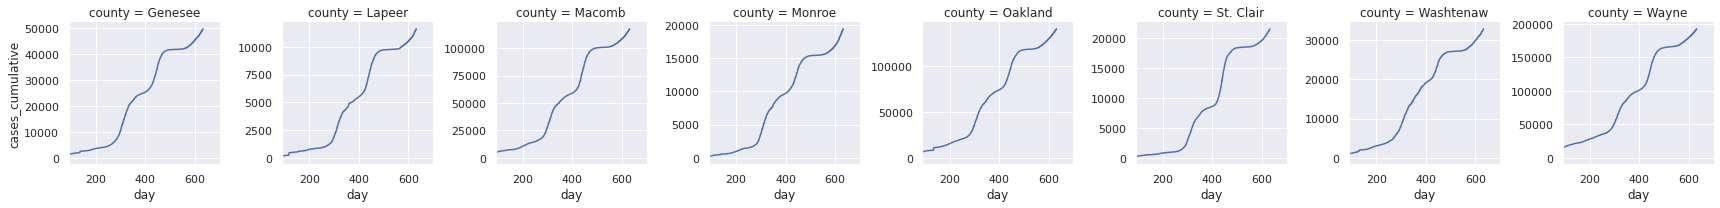

In [40]:
g = sns.FacetGrid(semich_df, col="county", sharey=False)
g = g.map(plt.plot, "day", "cases_cumulative")
g.set(xlim=(90,x_end_day))

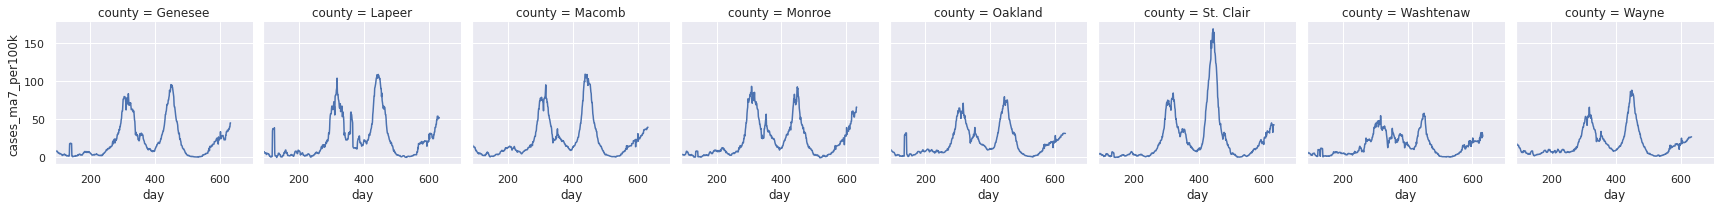

In [41]:
g = sns.FacetGrid(semich_df, col="county", sharey=True)
g = g.map(plt.plot, "day", "cases_ma7_per100k")
g.set(xlim=(90,x_end_day))
g.savefig('semich_7ma_cases_per100k.jpg')

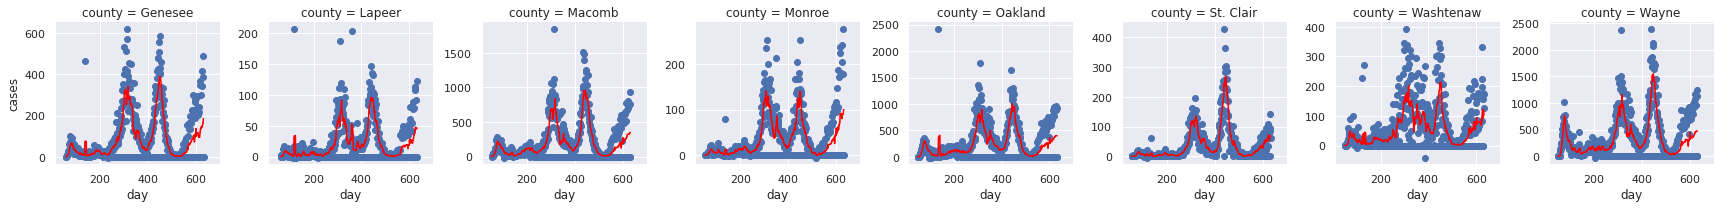

In [42]:
g = sns.FacetGrid(semich_df, col="county", sharey=False)
g = g.map(plt.plot, "day", "cases_ma7", color="red")
g = g.map(plt.scatter, "day", "cases")
g.set(xlim=(10,x_end_day))
g.savefig('semich_cases.jpg')

In [43]:
semich_weekly_df.to_csv('semich_weekly_df.csv', index=False)

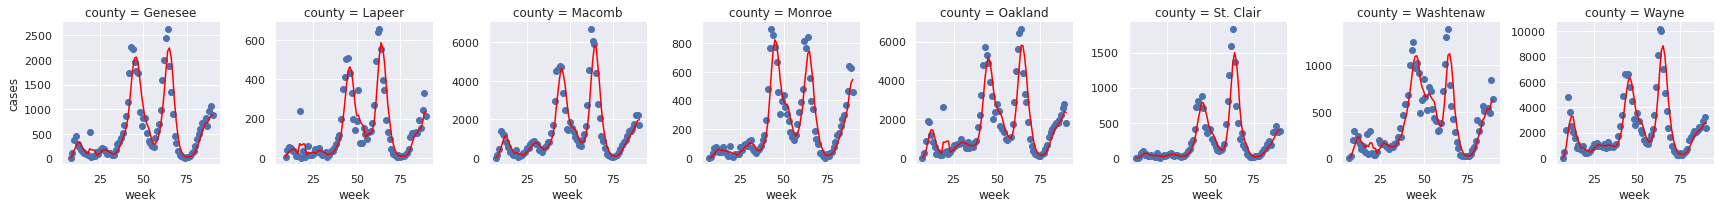

In [44]:
g = sns.FacetGrid(semich_weekly_df, col="county", sharey=False)
g = g.map(plt.plot, "week", "cases_ma4", color="red")
g = g.map(plt.scatter, "week", "cases")
#g.set(xlim=(10, x_end_day))
g.savefig('semich_weekly_cases.jpg')

In [45]:
title = 'Daily cases through {}'.format(dn.strftime('%Y-%m-%d'))
title

'Daily cases through 2021-10-14'

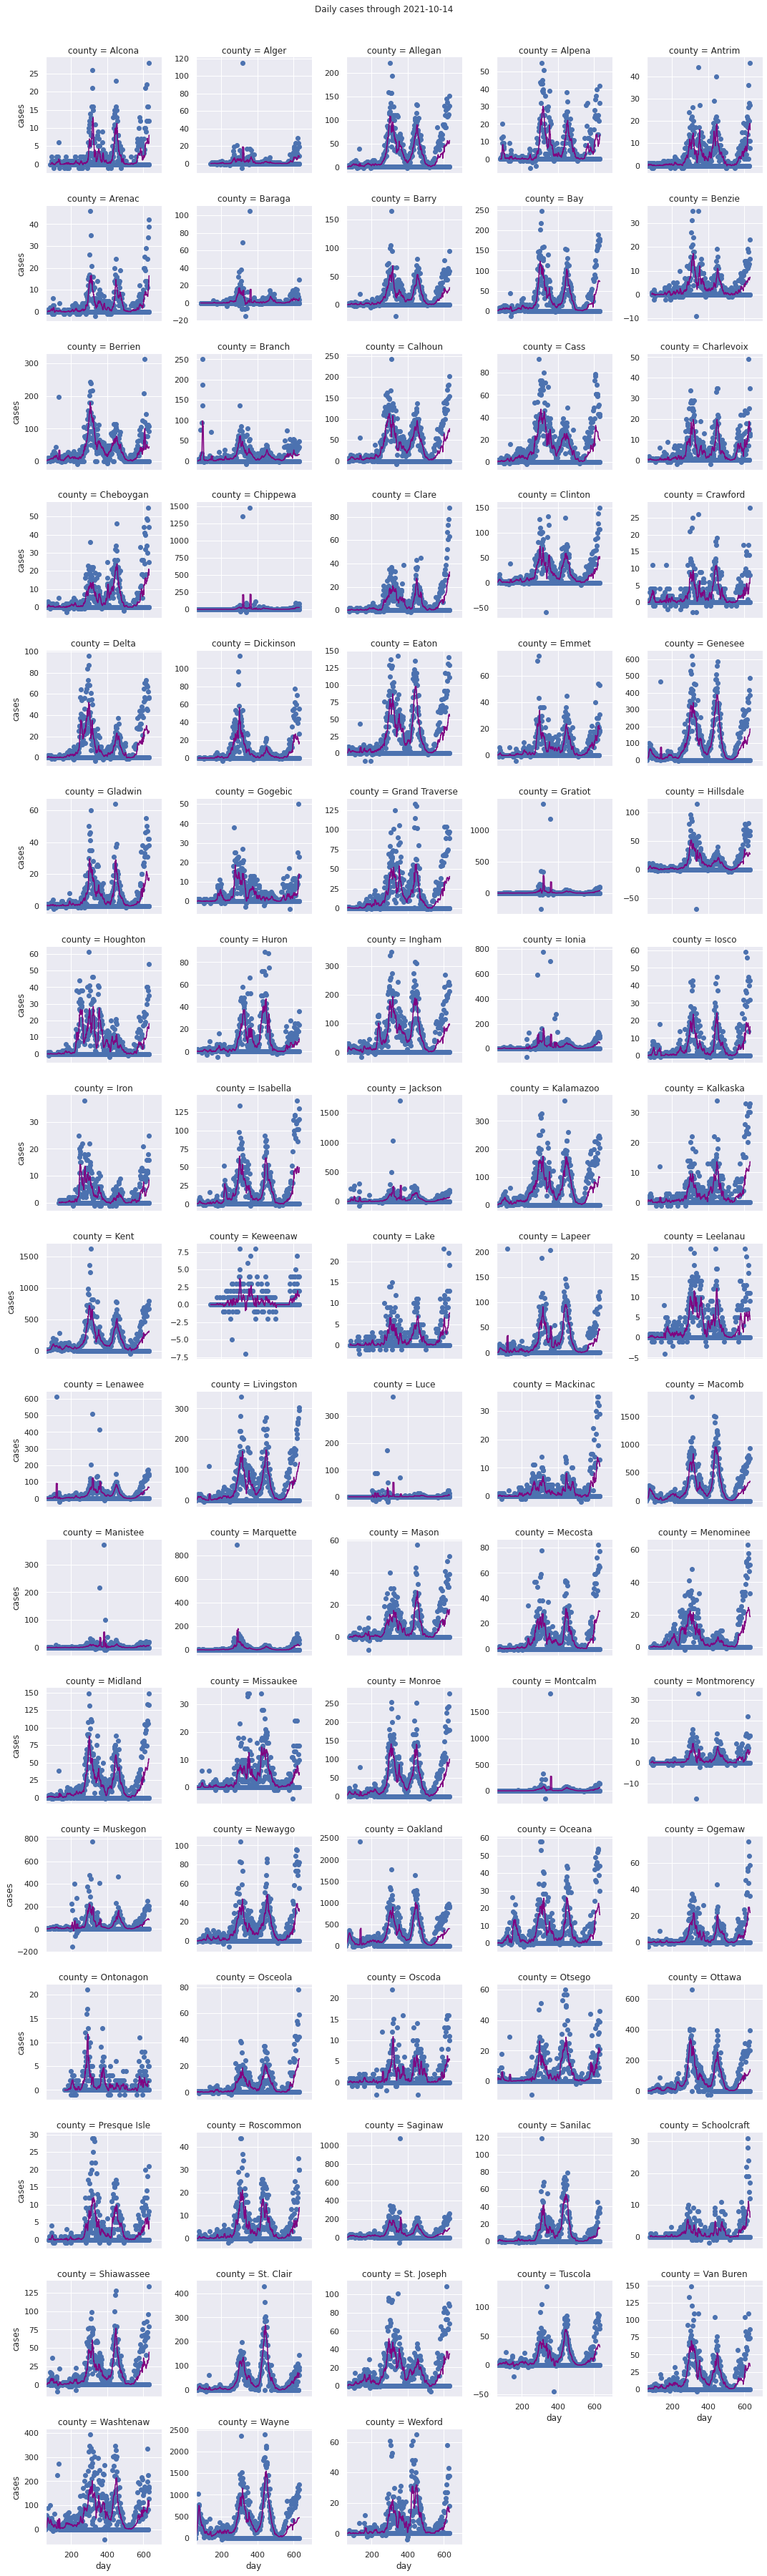

In [46]:
g_mich_cases = sns.FacetGrid(mich_df, col="county", sharey=False, 
                         col_wrap=5)
g_mich_cases = g_mich_cases.map(plt.plot, "day", "cases_ma7", color="purple")
g_mich_cases = g_mich_cases.map(plt.scatter, "day", "cases")

g_mich_cases.set(xlim=(60,x_end_day))

plt.subplots_adjust(top=0.96)
g_mich_cases.fig.suptitle(title) # can also get the figure from plt.gcf()

g_mich_cases.savefig("mich_cases.jpg")

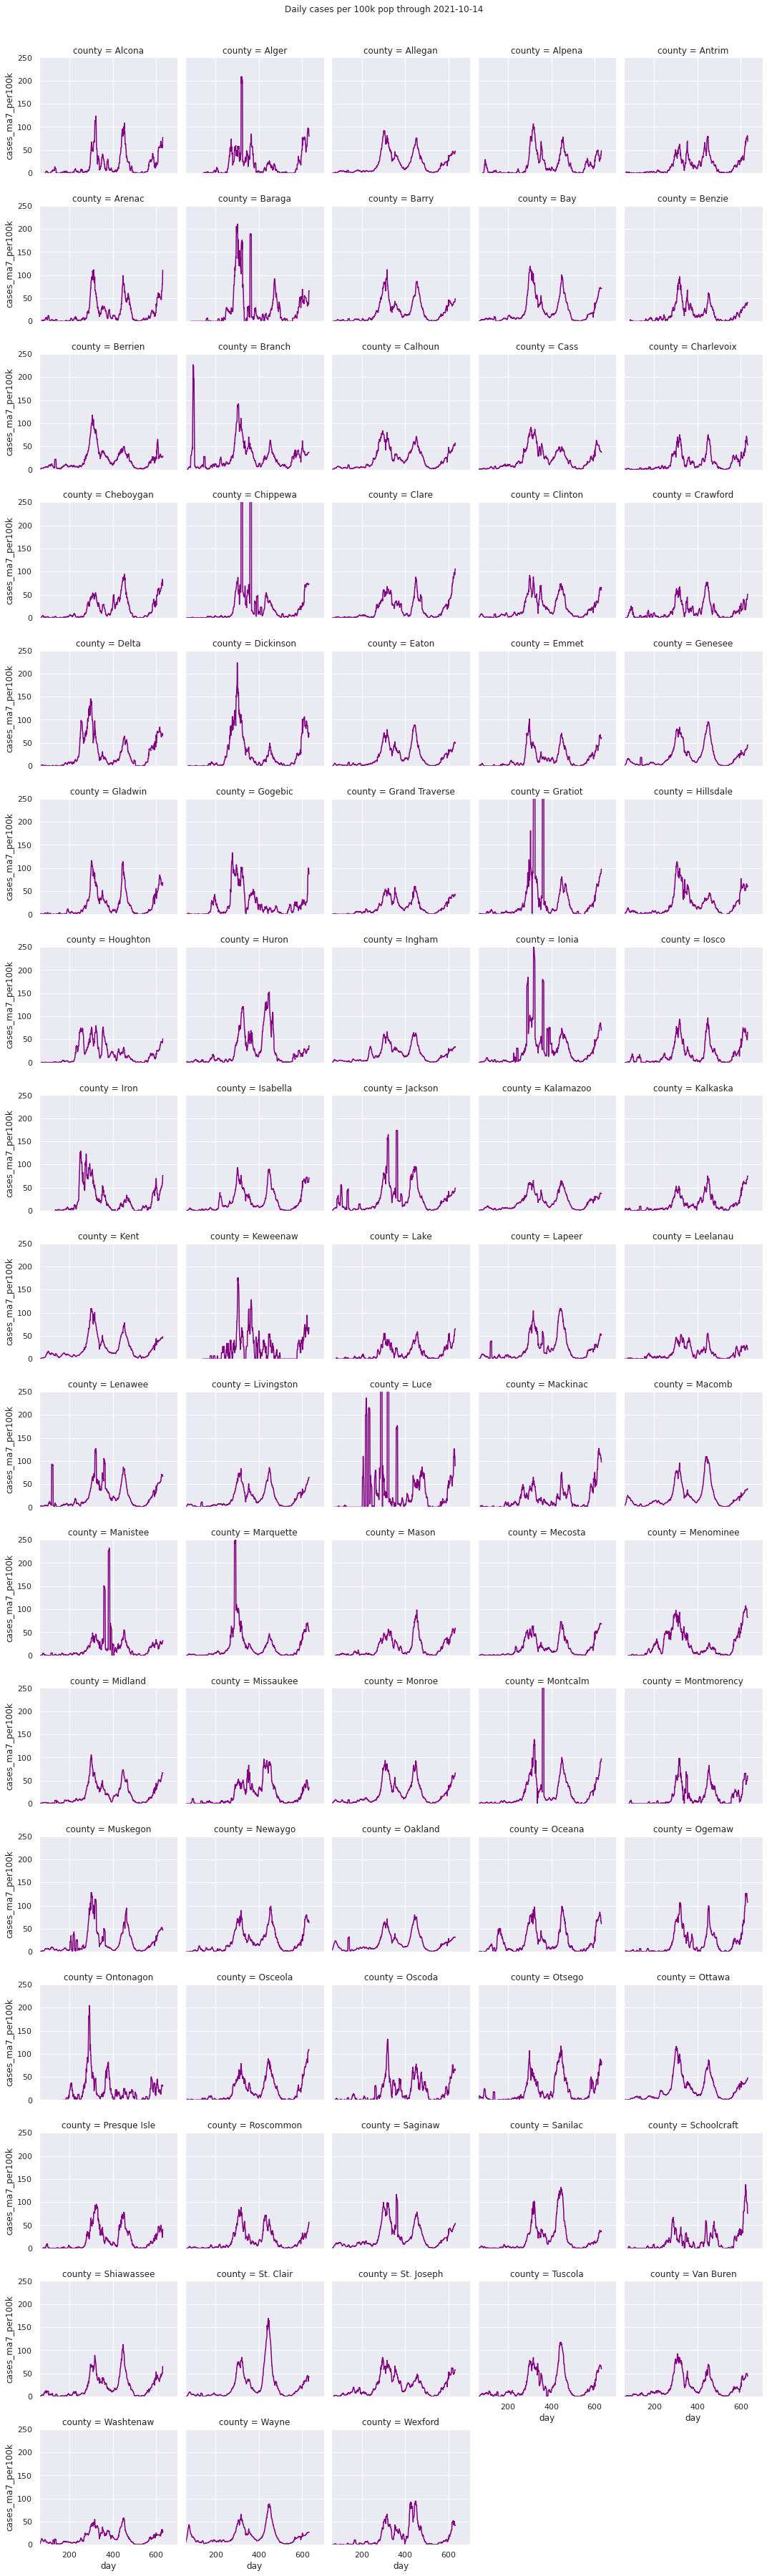

In [47]:
title = 'Daily cases per 100k pop through {}'.format(dn.strftime('%Y-%m-%d'))
g_mich_cases = sns.FacetGrid(mich_df, col="county", sharey=True, 
                         col_wrap=5)
g_mich_cases = g_mich_cases.map(plt.plot, "day", "cases_ma7_per100k", color="purple")

g_mich_cases.set(xlim=(60,x_end_day), ylim=(0,250))

plt.subplots_adjust(top=0.96)
g_mich_cases.fig.suptitle(title) # can also get the figure from plt.gcf()

g_mich_cases.savefig("mich_cases_per100k.png")

In [48]:
semich_cases_by_date = semich_df.groupby(['date'])[['cases', 'cases_cumulative']].sum()

In [49]:
semich_cases_by_date.to_csv('semich_cases_by_date.csv')

In [50]:
semich_cases_by_date

,cases,cases_cumulative
date,,
2020-03-10,0.0,2
2020-03-11,0.0,2
2020-03-12,2.0,7
2020-03-13,9.0,17
2020-03-14,7.0,25
...,...,...
2021-10-10,0.0,577854
2021-10-11,4020.0,581874
2021-10-12,274.0,582148


<AxesSubplot:xlabel='date'>

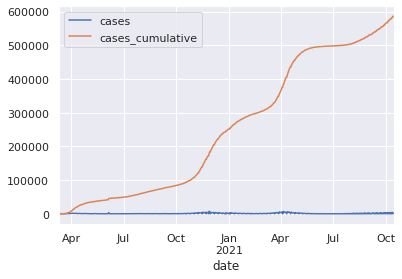

In [51]:
semich_cases_by_date.plot()

In [52]:
some_states = ['TX', 'NY', 'NC', 'FL', 'CA', 'CO', 'GA']
some_states_df = NYT_states_df.loc[NYT_states_df['st'].isin(some_states)]

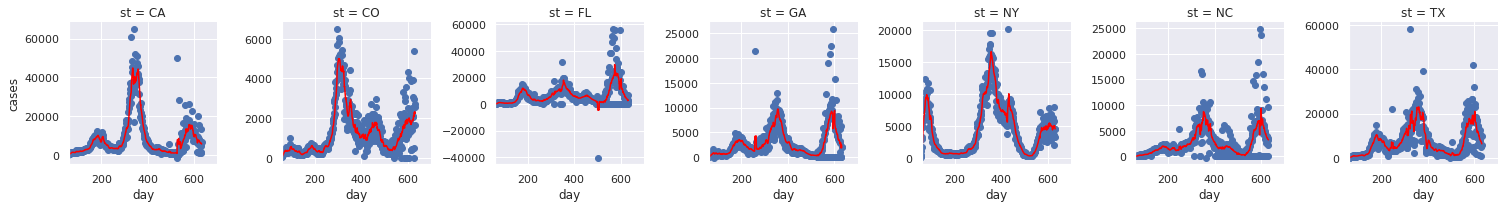

In [53]:
g = sns.FacetGrid(some_states_df, col="st", sharey=False)
g = g.map(plt.plot, "day", "cases_ma7", color="red")
g = g.map(plt.scatter, "day", "cases")
g.set(xlim=(60,x_end_day))

In [54]:
abbrevs = [state.abbr for state in us.states.STATES]

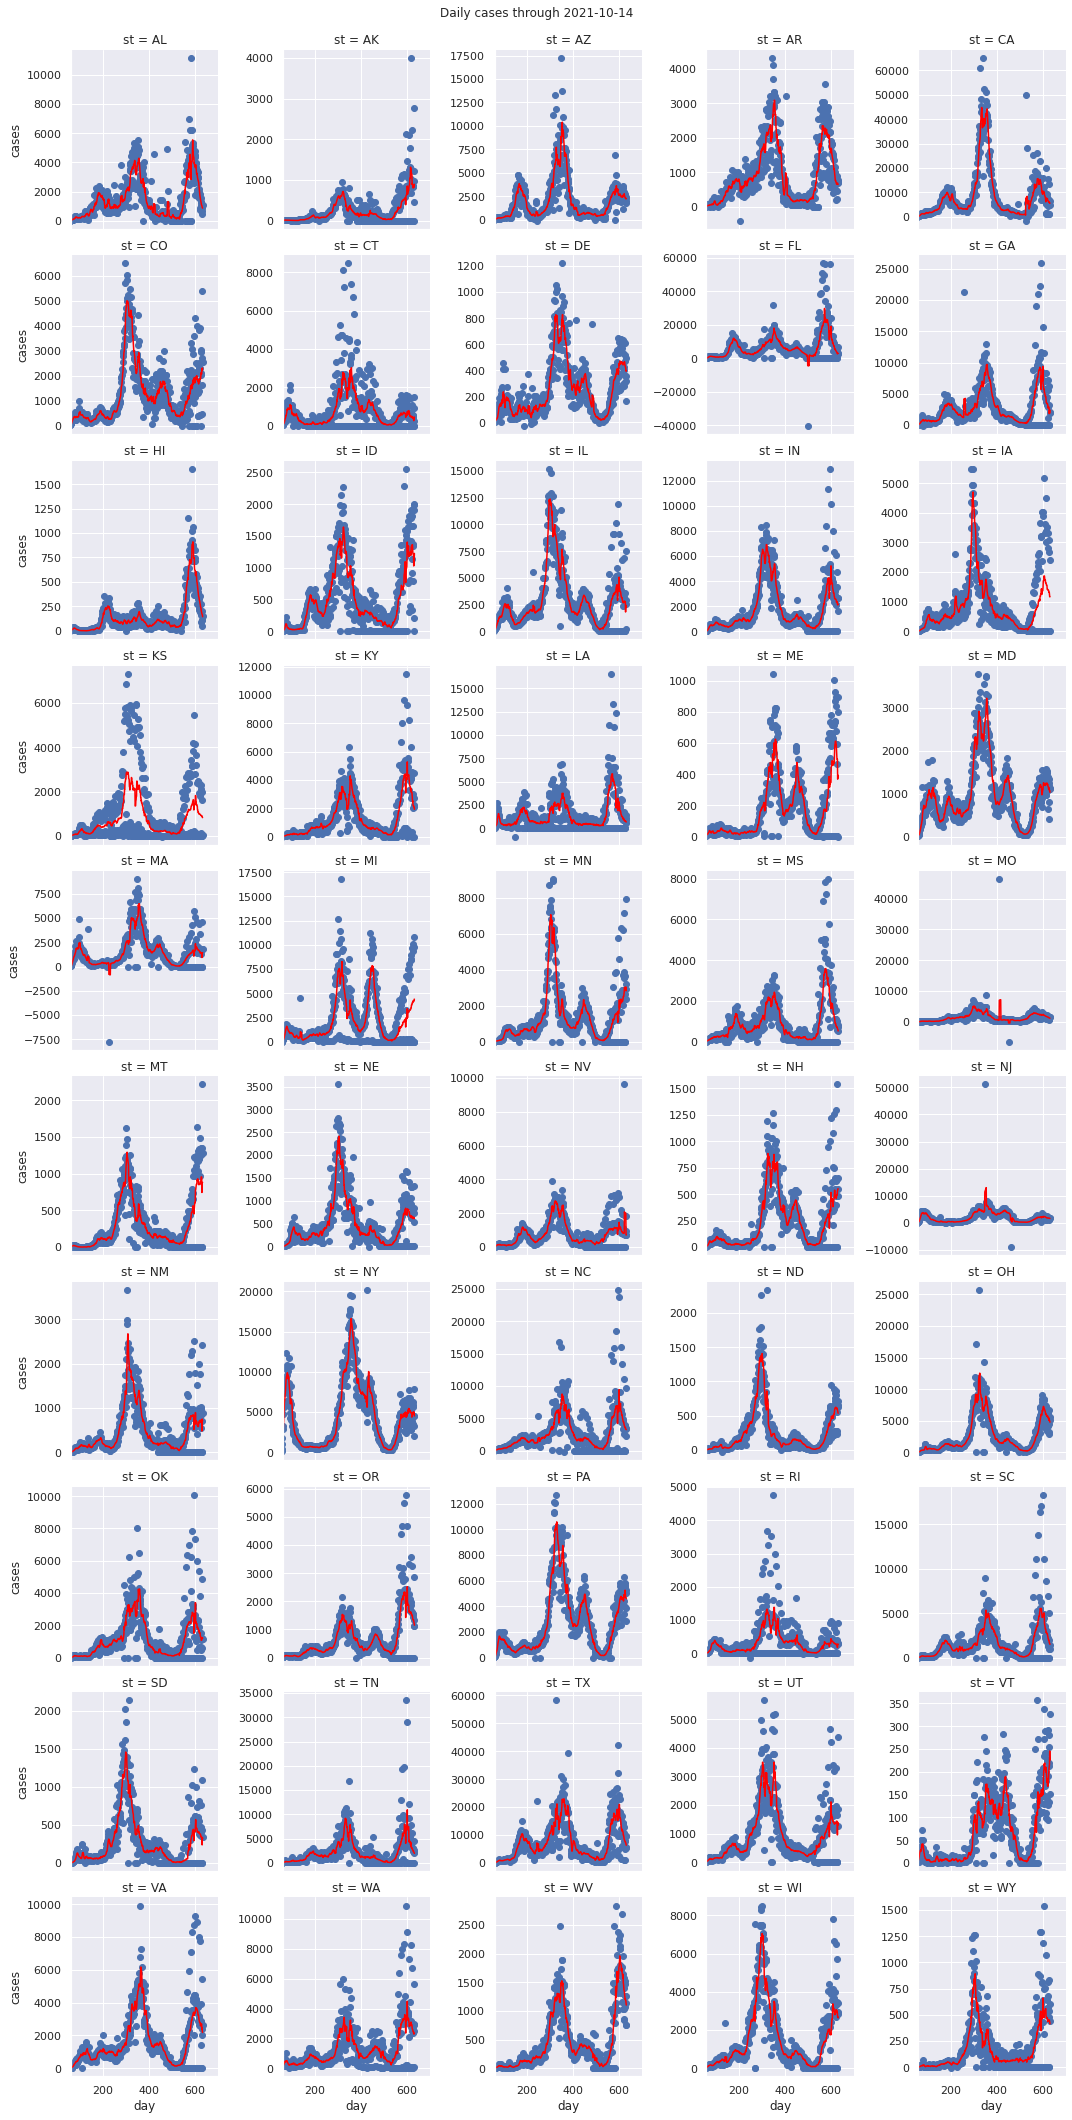

In [55]:
title = 'Daily cases through {}'.format(dn.strftime('%Y-%m-%d'))
g_states_cases = sns.FacetGrid(NYT_states_df, col="st", sharey=False, 
                         col_wrap=5, col_order=abbrevs)
g_states_cases = g_states_cases.map(plt.plot, "day", "cases_ma7", color="red")
g_states_cases = g_states_cases.map(plt.scatter, "day", "cases")
g_states_cases.set(xlim=(60,x_end_day))

plt.subplots_adjust(top=0.96)
g_states_cases.fig.suptitle(title) # can also get the figure from plt.gcf()

g_states_cases.savefig("us_cases.png")

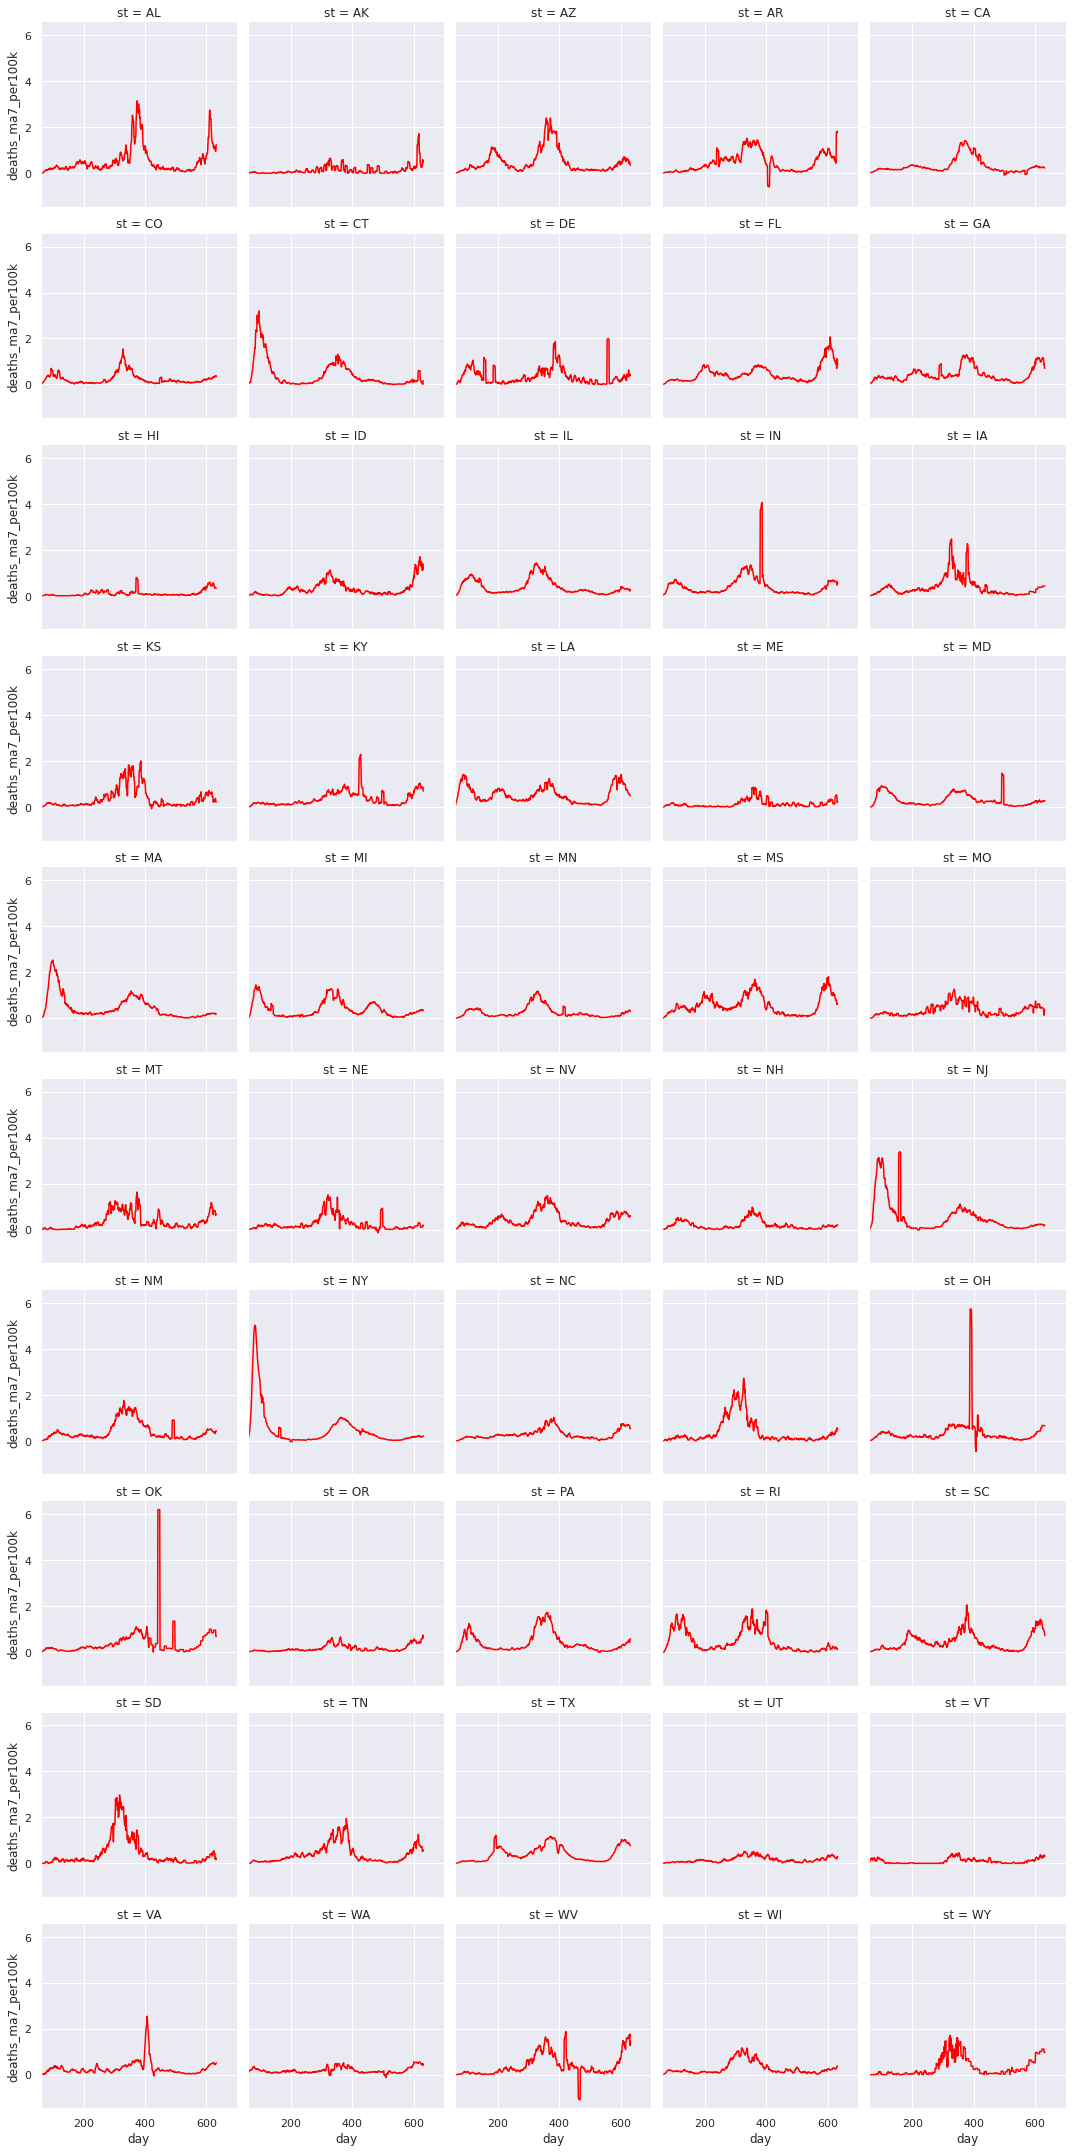

In [56]:
title = 'Daily deaths per 100k pop through {}'.format(dn.strftime('%Y-%m-%d'))
g_states_deaths = sns.FacetGrid(NYT_states_df, col="st", sharey=True, 
                         col_wrap=5, col_order=abbrevs)
g_states_deaths = g_states_deaths.map(plt.plot, "day", "deaths_ma7_per100k", color="red")
g_states_deaths.set(xlim=(60,x_end_day))

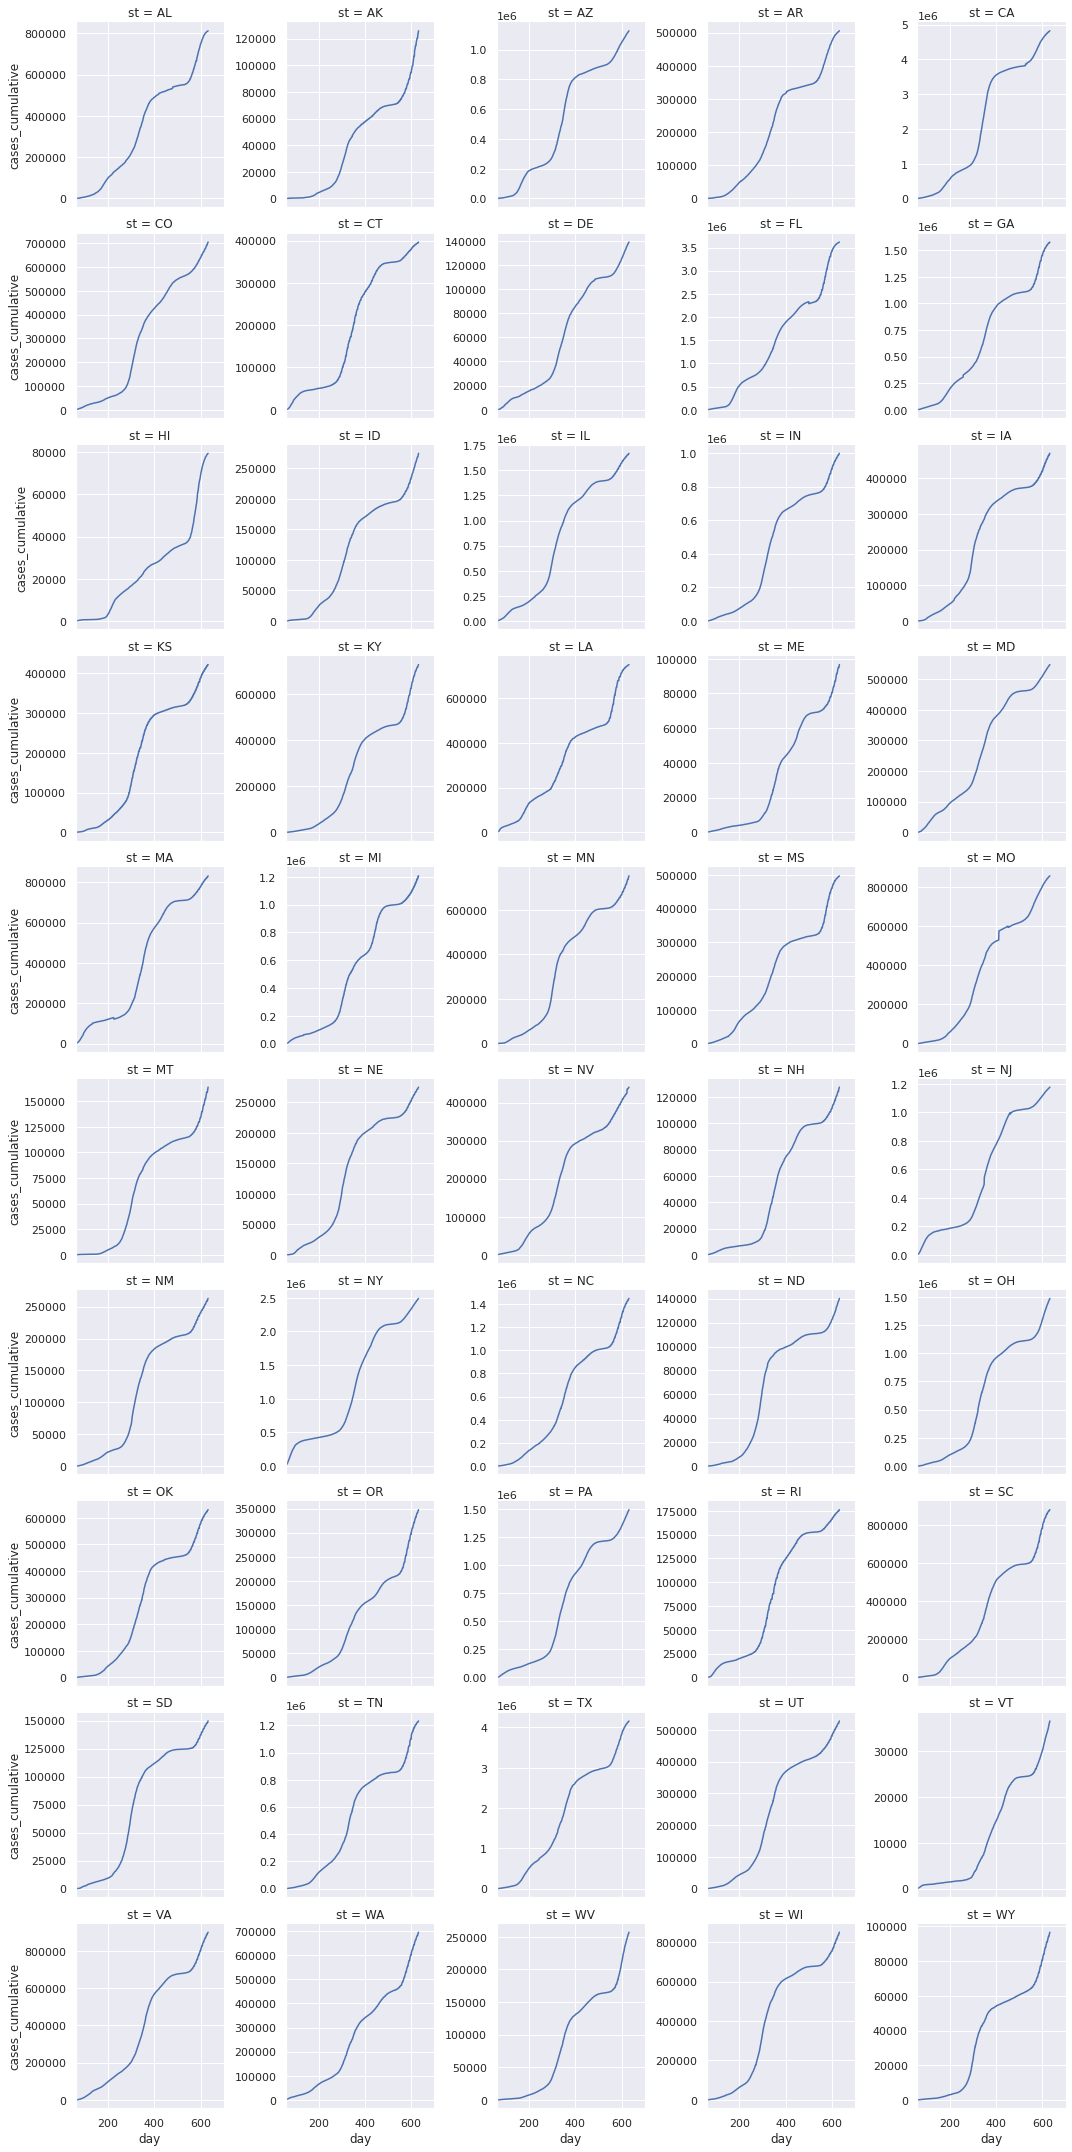

In [57]:
g_states_cases_cum = sns.FacetGrid(NYT_states_df, col="st", sharey=False, 
                         col_wrap=5, col_order=abbrevs)
g_states_cases_cum = g_states_cases_cum.map(plt.plot, "day", "cases_cumulative")
g_states_cases_cum.set(xlim=(60,x_end_day))

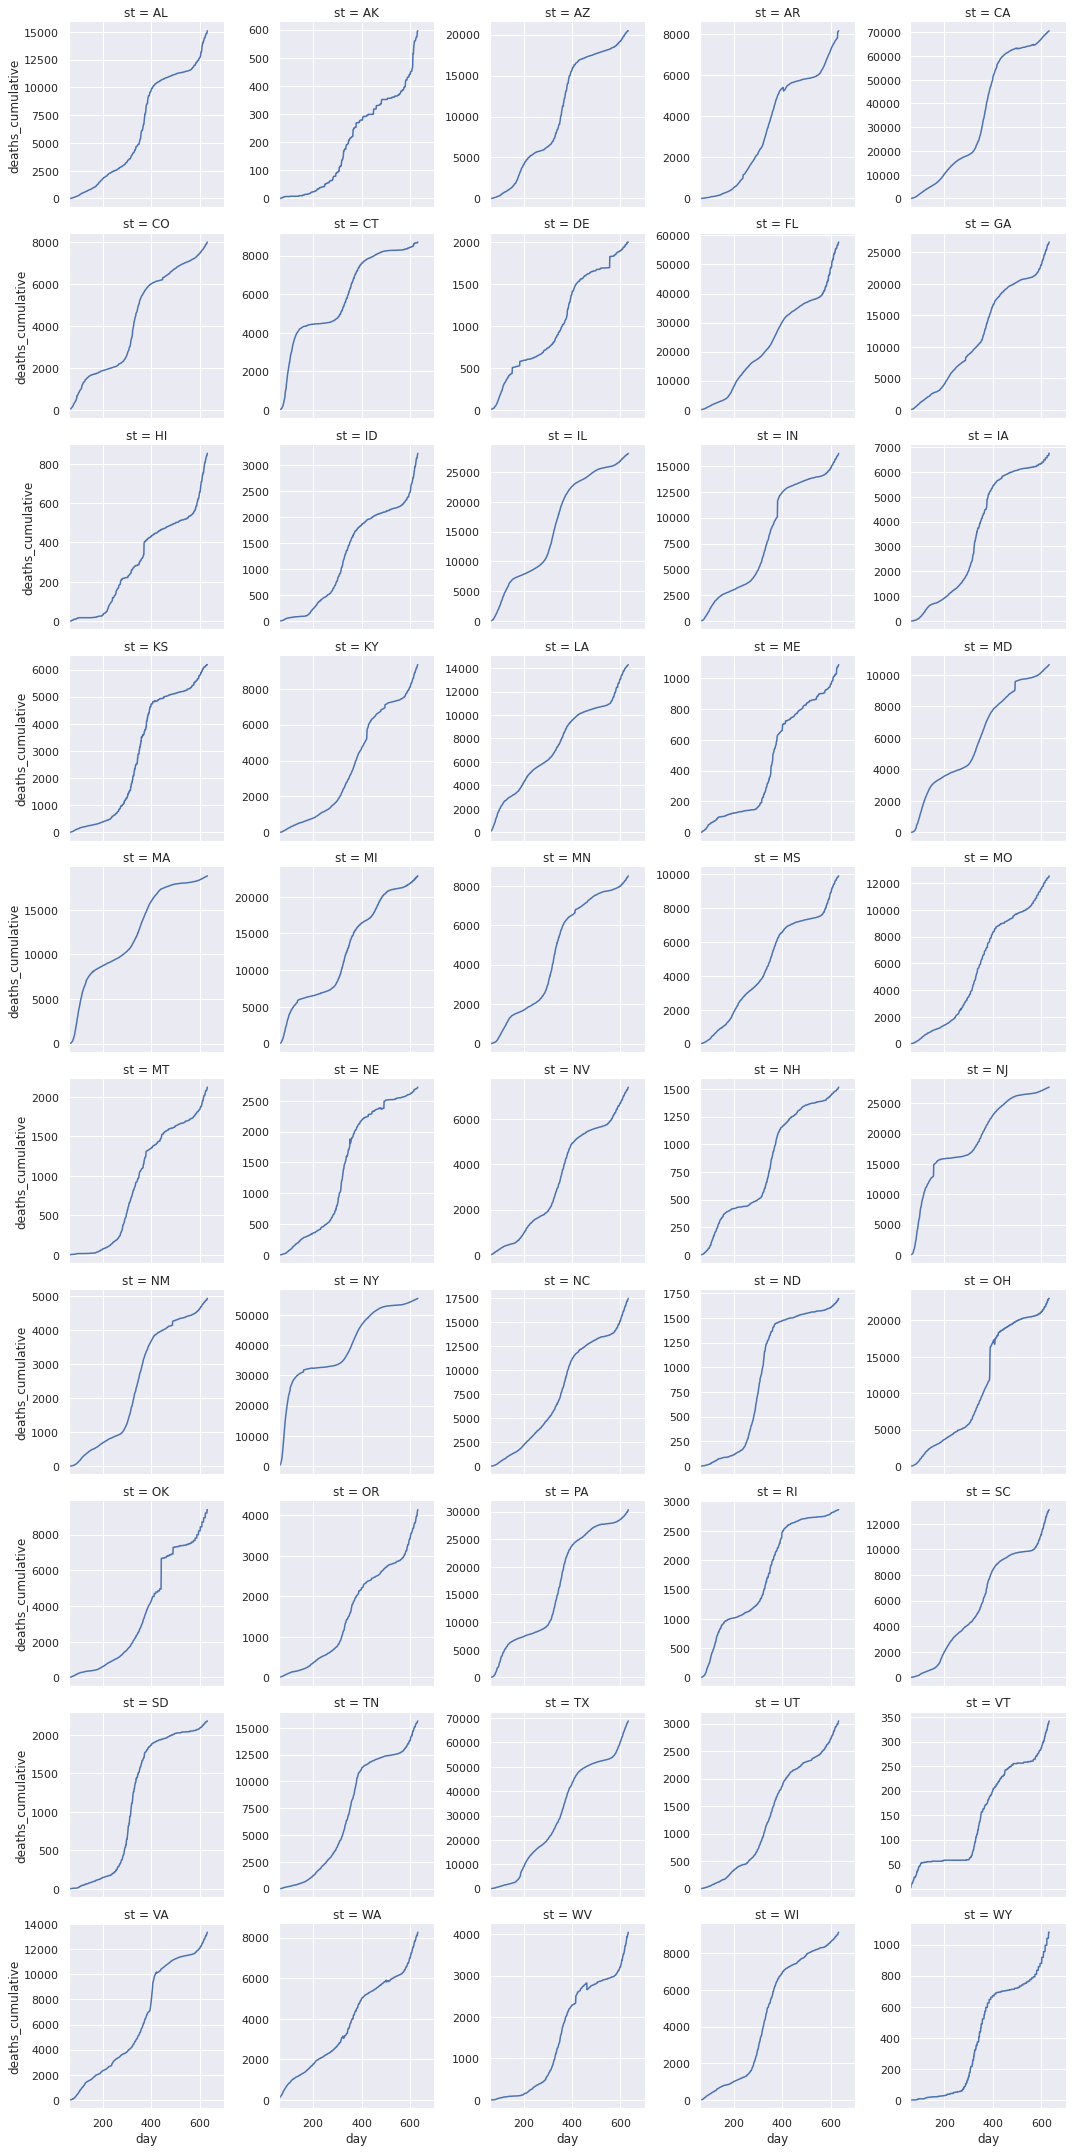

In [58]:
g_states_deaths_cum = sns.FacetGrid(NYT_states_df, col="st", sharey=False, 
                         col_wrap=5, col_order=abbrevs)
g_states_deaths_cum = g_states_deaths_cum.map(plt.plot, "day", "deaths_cumulative")
g_states_deaths_cum.set(xlim=(60,x_end_day))